In [1]:
config = {
    "path": {
        "dataset_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\lob_data",
        "model_path":"C:\\Users\\Cheon\\Dev\\deepcheese\\models"
    },

    "dataset": {
        "ticker": "KQ150",
        "open": "090000",
        "close": "154500",
        "orderbook_level": 5,
        "time_window": 100,
        "price_window" : 10,
        "max_amount": 5,
        "train_ratio": 0.5,
        "val_ratio": 0.2,
        "test_ratio": 0.3,
        "predict_horizon": 100,
        "threshold": 0.0003
    }
}

In [2]:
import os
import glob
import csv
import numpy as np
import matplotlib.pyplot as plt


_config_path = config["path"]
_config_dataset = config["dataset"]


def get_file_path(data_type, ticker, date="*"):
    match data_type:
        case "tradeprint":
            filename1 = "H0IFCNT0"
        case "orderbook":
            filename1 = "H0IFASP0"

    match ticker:
        case "KS200":
            filename2 = "101T*"
        case "KQ150":
            filename2 = "106T*"

    if date == "*":
        return os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv")
    else:
        return glob.glob(os.path.join(_config_path["dataset_path"], f"{filename1}_{filename2}_{date}.csv"))[0]


def get_file_list(data_type, ticker):
    return glob.glob(get_file_path(data_type, ticker))


def get_days_list(ticker):
    def extract_days(file_list):
        day_list = []
        for filename in file_list:
            day_list.append(filename.split('.')[0].split('_')[-1])
        return day_list

    # return days which has coupled tradeprint and orderbook data
    day_list_1 = extract_days(get_file_list("tradeprint", ticker))
    day_list_2 = extract_days(get_file_list("orderbook", ticker))
    intersect_day = list(set(day_list_1) & set(day_list_2))
    intersect_day.sort()
    return intersect_day


def load_orderbook_data(filename):
    mul_fac = 10
    orderbook_level = 5

    time_data = []
    orderbook_data = []

    with open(filename, 'r', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for idx, row in enumerate(reader):
            temp_timestamp = row[1]
            update = len(time_data) == 0 or temp_timestamp != time_data[-1]
            if (not row[2] == '0.00') and update:
                # Process orderbook data in single timestamp
                temp_orderbook_data = []
                for i in range(1, orderbook_level + 1):
                    single_level = [
                        ###################################################
                        int(float(row[1+i])*mul_fac), # price  | ask side
                        int(row[21+i]),               # volume |
                        ###################################################
                        int(float(row[6+i])*mul_fac), # price  | bid side
                        int(row[26+i])                # volume |
                        ###################################################
                    ]
                    temp_orderbook_data.append(single_level)
                time_data.append(temp_timestamp)
                orderbook_data.append(temp_orderbook_data)
    # sparse sampling
    time_data = np.array(time_data)[::1]
    orderbook_data = np.array(orderbook_data)[::1]
    return time_data, orderbook_data


In [3]:
import torch
import numpy as np


class MovingWindow:
    def __init__(self, day):
        self.day = day
        self.ticker = _config_dataset["ticker"]
        self.level = _config_dataset["orderbook_level"]
        self.T = _config_dataset["time_window"]
        self.W = _config_dataset["price_window"]
        self.max_quantity = _config_dataset["max_amount"]
        self.predict_horizon = _config_dataset["predict_horizon"]
        self.threshold = _config_dataset["threshold"]


        file_path = get_file_path("orderbook", self.ticker, day)
        self.orderbook_time, self.orderbook_data = load_orderbook_data(file_path)
        self.movingwindow = []
        self.ticks = []

        self.start_idx = max(self.T - 1, self.predict_horizon)
        self.end_idx = len(self.orderbook_data) - self.predict_horizon - 1

        self.midprice = []
        self.ask1 = []
        self.bid1 = []
        self.midprice_idx = []
        self.__fill_movingwindow__(self.orderbook_data)

        self.label = []
        self.__fill_label__()

    def __len__(self):
        return self.end_idx - self.start_idx + 1
    
    def __moving_window_shot__(self, lob, ticks, data_min, data_max):
        lob_shot = lob.copy()
        lob_shot[:, 1:4:2] = np.minimum(lob_shot[:, 1:4:2], self.max_quantity)
        lob_shot[:,3] = -lob_shot[:,3]

        for i in range(1, lob_shot.shape[0]):
            lob_shot[i, 1:4:2] = lob_shot[i-1, 1:4:2] + lob_shot[i, 1:4:2]

        ask_side = lob_shot[:, 0:2]
        bid_side = lob_shot[::-1, 2:4]

        midprice = (ask_side[0, 0] + bid_side[0, 0]) / 2
        ask1 = ask_side[0, 0]
        bid1 = bid_side[0, 0]
        midprice_idx = round(midprice - (data_min - self.W))

        moving_window_shot = np.zeros(ticks.shape)

        # bid side
        for i in range(5):
            if i == 0:
                start_idx = 0
            else:
                start_idx = bid_side[i-1, 0] - (data_min - self.W) + 1
            end_idx = bid_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = bid_side[i, 1]

        # ask side
        for i in range(5):
            if i == 4:
                end_idx = len(moving_window_shot)
            else:
                end_idx = ask_side[i + 1, 0] - (data_min - self.W) + 1
            start_idx = ask_side[i, 0] - (data_min - self.W)
            moving_window_shot[start_idx:end_idx+1] = ask_side[i, 1]

        return moving_window_shot, midprice, ask1, bid1, midprice_idx


    def __fill_movingwindow__(self, data):
        processed_data = []
        midprice = []
        ask1 = []
        bid1 = []
        midprice_idx = []

        data_min = np.min(data[:,:,0:3:2].flatten())
        data_max = np.max(data[:,:,0:3:2].flatten())
        ticks = np.arange(data_min - self.W, data_max + self.W + 1, 1)

        for i in range(data.shape[0]):
            lob_shot, midprice_, ask_1, bid_1, midprice_idx_ = self.__moving_window_shot__(data[i], ticks, data_min, data_max)
            processed_data.append(lob_shot)
            midprice.append(midprice_)
            ask1.append(ask_1)
            bid1.append(bid_1)
            midprice_idx.append(midprice_idx_)

        self.movingwindow = np.array(processed_data) / (self.max_quantity * 5)
        self.ticks = ticks
        self.midprice = np.array(midprice)
        self.ask1 = np.array(ask1)
        self.bid1 = np.array(bid1)
        self.midprice_idx = np.array(midprice_idx)
        

    def __fill_label__(self):
        label = np.zeros(self.end_idx - self.start_idx + 1)

        for index in range(self.end_idx - self.start_idx + 1):
            index_re = index + self.start_idx
            m_prev = np.mean(self.midprice[index_re - self.predict_horizon:index_re])
            m_next = np.mean(self.midprice[index_re + 1:index_re + self.predict_horizon + 1])
            l = (m_next - m_prev) / m_prev

            if l > self.threshold:
                tmp_label = 2
            elif l < -self.threshold:
                tmp_label = 0
            else:
                tmp_label = 1
            label[index] = tmp_label
        self.label = label
        # self.movingwindow = self.movingwindow[self.start_idx: self.end_idx + 1]
        # self.midprice_idx = self.midprice_idx[self.start_idx: self.end_idx + 1]
        # self.midprice = self.midprice[self.start_idx: self.end_idx + 1]
        # self.ask1 = self.ask1[self.start_idx: self.end_idx + 1]
        # self.bid1 = self.bid1[self.start_idx: self.end_idx + 1]

    def __getitem__(self, index):
        index_re = index + self.start_idx
        shot = self.movingwindow[index_re-self.T+1:index_re+1,
                                 self.midprice_idx[index_re]-self.W:self.midprice_idx[index_re]+self.W].T
        return np.expand_dims(shot, axis=0), self.label[index]
    
    def get_price(self):
        return self.midprice[self.start_idx:self.end_idx + 1], \
               self.ask1[self.start_idx:self.end_idx + 1], \
               self.bid1[self.start_idx:self.end_idx + 1]


In [9]:
#from multiprocessing import Pool
from ray.util.multiprocessing import Pool

class Dataset:
    def __init__(self, days):
        self.days = days
        self.day_datasets = []

        with Pool() as pool:
            self.day_datasets = pool.map(MovingWindow, self.days)


def get_datasets(verbose=False):
    days = get_days_list(_config_dataset["ticker"])

    val_length = max(round(len(days) * _config_dataset["val_ratio"]), 1)
    test_length = max(round(len(days) * _config_dataset["test_ratio"]), 1)
    train_length = len(days) - (val_length + test_length)

    train_days = days[:train_length]#[:2]
    val_days = days[train_length:train_length + val_length]#[:1]
    test_days = days[train_length + val_length:]#[:1]

    if verbose:
        print(f"% {len(train_days)} days for train ({train_days[0]} ~ {train_days[-1]})")
        print(f"% {len(val_days)} days for validation ({val_days[0]} ~ {val_days[-1]})")
        print(f"% {len(test_days)} days for test ({test_days[0]} ~ {test_days[-1]})")

    train_dataset = Dataset(train_days)
    val_dataset = Dataset(val_days)
    test_dataset = Dataset(test_days)

    return train_dataset, val_dataset, test_dataset


In [10]:
train_dataset, val_dataset, test_dataset = get_datasets(verbose=True)

% 38 days for train (2023-04-03 ~ 2023-05-26)
% 15 days for validation (2023-05-30 ~ 2023-06-21)
% 23 days for test (2023-06-22 ~ 2023-07-24)


In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset.day_datasets[0], batch_size=64, shuffle=False)

In [12]:
test_dataset.day_datasets[0][2][0].shape

(1, 20, 100)

In [13]:
for data, label in test_loader:
    print(data.shape, label.shape)
    break

torch.Size([64, 1, 20, 100]) torch.Size([64])


C:\Users\Cheon\Dev\deepcheese\.venv\Lib\site-packages\torch\utils\data\_utils\collate.py:171: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:212.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


In [14]:
def get_loader(dataset, batch_size):
    loaders = []
    for day_dataset in dataset.day_datasets:
        loaders.append(torch.utils.data.DataLoader(day_dataset, batch_size=batch_size, shuffle=True))
    return loaders

train_loader = get_loader(train_dataset, 512)
val_loader = get_loader(val_dataset, 512)
test_loader = get_loader(test_dataset, 512)

In [15]:
def get_label(dataset):
        label = []
        for day_dataset in dataset.day_datasets:
            label.append(day_dataset.label)
        label = np.concatenate(label, 0)
        return label


for dataset in [train_dataset, val_dataset, test_dataset]:
    label = get_label(dataset)
    print("% label distribution")
    for i in [0, 1, 2]:
        print(len(np.where(label == i)[0]))

% label distribution
246208
343859
250294
% label distribution
86304
153492
87580
% label distribution
146713
214710
159929


In [16]:
for day_loader in train_loader:
    for data, label in day_loader:
        print(data.shape, label.shape)
        break
    break

torch.Size([512, 1, 20, 100]) torch.Size([512])


In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class FeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.input_size = _config_dataset["time_window"] * _config_dataset["price_window"] * 2
        self.fc0 = torch.nn.Linear(self.input_size, 100)
        self.fc1 = torch.nn.Linear(100, 10)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = x.reshape(-1, self.input_size)
        out = self.fc0(x)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu(out)
        return out

class Classifier(torch.nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.fc = torch.nn.Linear(10, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        out = self.fc(x)
        return out
    
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [65]:
model = MLP().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


In [66]:
model(torch.rand((64, 1, _config_dataset["price_window"] * 2, _config_dataset["time_window"])).to(device)).shape

torch.Size([64, 3])

In [67]:
import torch
import numpy as np


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = []
    running_acc = []
    for day_loader in train_loader:
        for input, target in day_loader:
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.int64)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, target)
            acc = (torch.count_nonzero(torch.argmax(output, dim=1) == target).item()
                   / target.size(0))

            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())
            running_acc.append(acc)
    epoch_loss = np.mean(running_loss)
    epoch_acc = np.mean(running_acc)
    return epoch_loss, epoch_acc


def validation(model, test_loader, criterion, scheduler):
    model.eval()
    running_loss = []
    running_acc = []
    for day_loader in test_loader:
        for input, target in day_loader:
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.int64)

            output = model(input)
            loss = criterion(output, target)
            acc = (torch.count_nonzero(torch.argmax(output, dim=1) == target).item()
                   / target.size(0))

            running_loss.append(loss.item())
            running_acc.append(acc)
    epoch_loss = np.mean(running_loss)
    epoch_acc = np.mean(running_acc)
    scheduler.step(epoch_loss)
    return epoch_loss, epoch_acc

In [68]:
epochs = 5

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    val_epoch_loss, val_epoch_acc = validation(model, val_loader, criterion, scheduler)

    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")

Epoch 1/5
Train Loss: 0.8384 | Train Acc: 0.6164
Val Loss: 0.7926 | Val Acc: 0.6493
Epoch 2/5
Train Loss: 0.8122 | Train Acc: 0.6259
Val Loss: 0.7906 | Val Acc: 0.6494
Epoch 3/5
Train Loss: 0.8107 | Train Acc: 0.6259
Val Loss: 0.7907 | Val Acc: 0.6494
Epoch 4/5
Train Loss: 0.8095 | Train Acc: 0.6263
Val Loss: 0.7895 | Val Acc: 0.6492
Epoch 5/5
Train Loss: 0.8091 | Train Acc: 0.6262
Val Loss: 0.7886 | Val Acc: 0.6493


In [69]:
example_day = test_dataset.day_datasets[0]

midprice, ask1, bid1 = example_day.get_price()

In [70]:
example_loader = torch.utils.data.DataLoader(example_day, batch_size=512, shuffle=False)

pred = []
conf = []
for input, target in example_loader:
    input = input.to(device, dtype=torch.float)
    target = target.to(device, dtype=torch.int64)

    output = model(input)
    temp_pred = torch.argmax(output, dim=1).cpu().detach().numpy()
    temp_conf = np.max(torch.nn.functional.softmax(output, dim=1).cpu().detach().numpy(), axis=1)
    pred.append(temp_pred)
    conf.append(temp_conf)
pred = np.concatenate(pred, 0)
conf = np.concatenate(conf, 0)

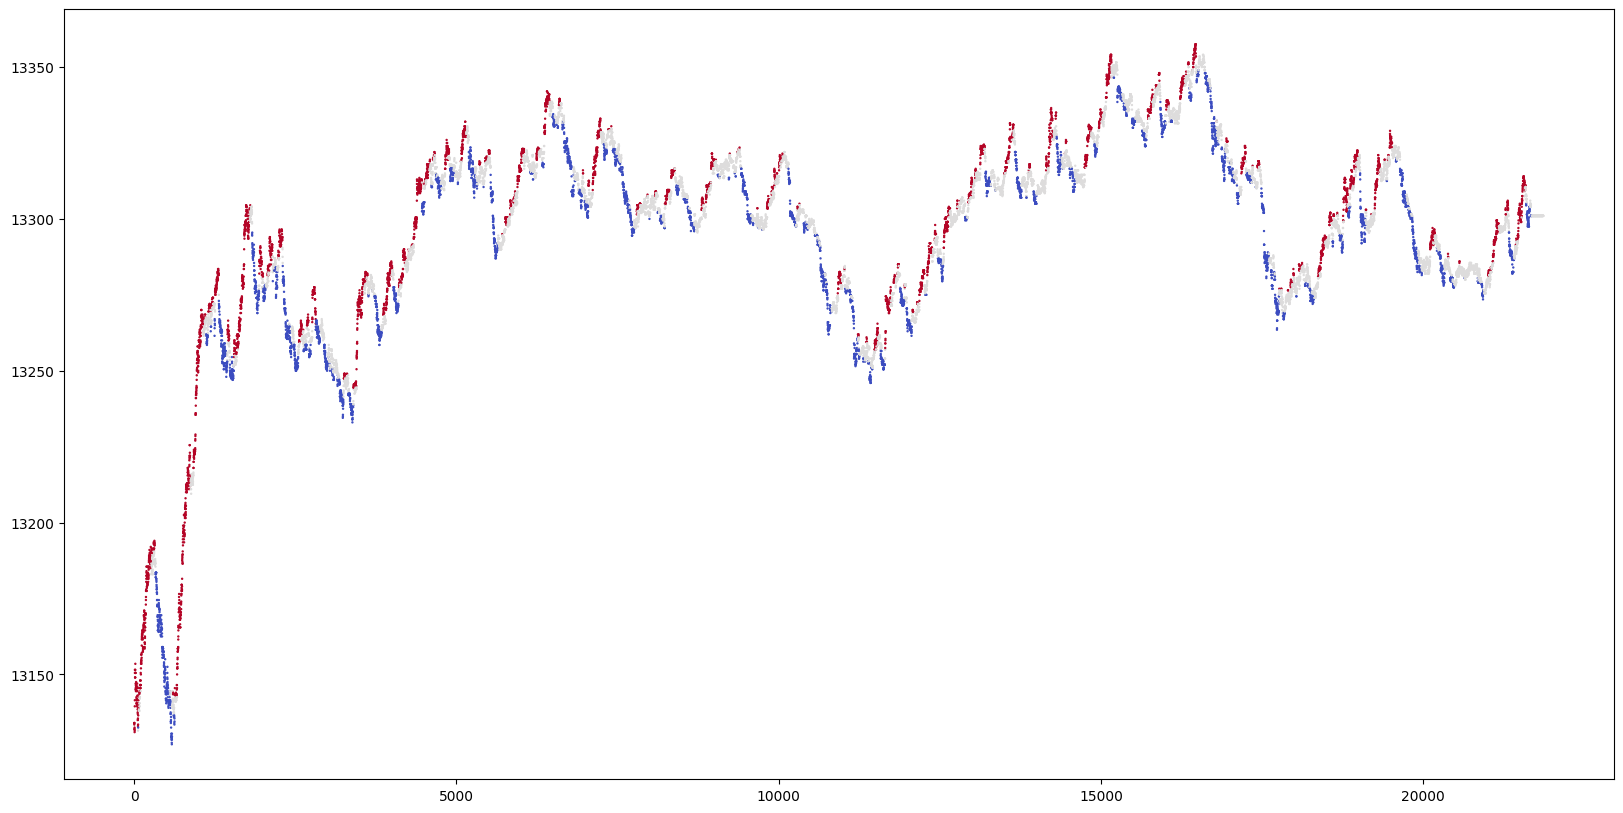

In [71]:
plt.figure(figsize=(20, 10))
plt.scatter(np.arange(len(midprice)), midprice, s=0.5, c=pred, cmap='coolwarm')

In [72]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(accuracy_score(example_day.label, pred))
print(classification_report(example_day.label, pred))
print(confusion_matrix(example_day.label, pred, normalize='true'))

0.6201061105012806
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64      6035
         1.0       0.54      0.66      0.60      8690
         2.0       0.74      0.55      0.63      7139

    accuracy                           0.62     21864
   macro avg       0.64      0.62      0.62     21864
weighted avg       0.64      0.62      0.62     21864

[[0.64092792 0.31963546 0.03943662]
 [0.20955121 0.66006904 0.13037975]
 [0.04146239 0.40467853 0.55385908]]


In [73]:
# freeze the model
for param in model.parameters():
    param.requires_grad = False

In [74]:
# reinforcement learning

class MarketEnv:
    def __init__(self, days) -> None:
        self.days = days
        with Pool() as pool:
            self.day_datasets = pool.map(MovingWindow, self.days)

        self.reset()

    def reset(self):
        self.day_idx = np.random.randint(len(self.days))
        self.day = self.days[self.day_idx]
        self.day_dataset = self.day_datasets[self.day_idx]
        self.day_len = len(self.day_dataset)
        self.max_position = 3
        self.fee = 0.003 / 100

        self.t = 0
        self.t_max = self.day_len - 1

        self.midprice, self.ask1, self.bid1 = self.day_dataset.get_price()
        self.cumulative_reward = np.zeros(self.day_len)
        self.position = np.zeros(self.day_len)
        self.cash = np.zeros(self.day_len)
        self.balance = np.zeros(self.day_len)
        
        self.long_inventory = []
        self.short_inventory = []

        return self.day_dataset[self.t][0], np.array([0.0])

    def step(self, action):
        self.t += 1
        
        # action: 0 - hold, 1 - buy, 2 - sell
        if action == 1 and self.position[self.t - 1] < self.max_position:
            position_change = 1
        elif action == 2 and self.position[self.t - 1] > -self.max_position:
            position_change = -1
        else:
            position_change = 0
        
        # trading price
        if position_change == 1:
            trade_price = self.ask1[self.t]
        elif position_change == -1:
            trade_price = self.bid1[self.t]
        else:
            trade_price = self.midprice[self.t]
        
        self.position[self.t] = self.position[self.t - 1] + position_change
        self.cash[self.t] = self.cash[self.t - 1] - trade_price * position_change - abs(position_change) * self.fee * trade_price
        self.balance[self.t] = self.cash[self.t] + self.position[self.t] * self.midprice[self.t]

        reward = self.balance[self.t] - self.balance[self.t - 1]
            
        self.cumulative_reward[self.t] = self.cumulative_reward[self.t - 1] + reward
        done = self.t == self.t_max

        if done:
            state = None
            info = {
                "position": self.position,
                "balance": self.balance,
                "cumulative_reward": self.cumulative_reward,
                "midprice": self.midprice
            }
        else:
            state = self.day_dataset[self.t][0]
            info = {
                "position": self.position[self.t],
                "balance": self.balance[self.t],
                "cumulative_reward": self.cumulative_reward[self.t],
                "midprice": self.midprice[self.t]
            }
        
        state_pos = np.array([self.position[self.t]/self.max_position])
        return state, state_pos, reward, done, info
    
    def evaluate_balance(self):
        self.position_history[self.t] = self.position
        self.balance_history[self.t] = self.balance
        self.cumulative_reward_history[self.t] = self.cumulative_reward
        return self.balance_history[-1]
    
    def close(self):
        pass
        

In [80]:
import torch.nn as nn

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(10+1, 3)
        self.relu = nn.ReLU()

    def forward(self, x, x_position):
        x = torch.cat((x, x_position), dim=1)
        x = self.fc1(x)
        forecast_y = torch.softmax(x, dim=1)
        return forecast_y
    

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(10+1, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x, x_position):
        x = torch.cat((x, x_position), dim=1)
        x = self.fc1(x)
        return x

In [83]:
lr = 1e-2
gamma = 0.99
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.data = []

        self.encoder = model.feature_extractor
        self.actor = Actor()
        self.critic = Critic()

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def pi(self, x, x_position):
        x = self.encoder(x)
        x = nn.functional.softmax(x, dim=1)
        x = self.actor(x, x_position)
        return x
    
    def v(self, x, x_position):
        x = self.encoder(x)
        x = nn.functional.softmax(x, dim=1)
        x = self.critic(x, x_position)
        return x
    
    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, s_pos_lst, a_lst, r_lst, s_prime_lst, s_pos_prime_lst, done_lst = [], [], [], [], [], [], []
        for transition in self.data:
            s, s_pos, a, r, s_prime, s_pos_prime, done = transition
            s_lst.append(s)
            s_pos_lst.append(s_pos)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            s_pos_prime_lst.append(s_pos_prime)
            done_mask = 0.0 if done else 1.0
            done_lst.append([done_mask])

        s_batch, s_pos_batch = torch.tensor(s_lst, dtype=torch.float), torch.tensor(s_pos_lst, dtype=torch.float)
        a_batch, r_batch = torch.tensor(a_lst), torch.tensor(r_lst, dtype=torch.float)
        s_prime_batch, s_pos_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float), torch.tensor(s_pos_prime_lst, dtype=torch.float)
        done_batch = torch.tensor(done_lst)

        self.data = []
        return s_batch, s_pos_batch, a_batch, r_batch, s_prime_batch, s_pos_prime_batch, done_batch
    
    def train(self):
        if len(self.data) < 5:
            return
        s, s_pos, a, r, s_prime, s_pos_prime, done = self.make_batch()
        s, s_pos, a, r, s_prime, s_pos_prime, done = s.to(device), s_pos.to(device), a.to(device), r.to(device), s_prime.to(device), s_pos_prime.to(device), done.to(device)

        td_target = r + gamma * self.v(s_prime, s_pos_prime) * done
        delta = td_target - self.v(s, s_pos)
        
        pi = self.pi(s, s_pos)
        pi_a = pi.gather(1, a)
        loss = -torch.log(pi_a) * delta.detach() + nn.functional.smooth_l1_loss(self.v(s, s_pos), td_target.detach())

        self.optimizer.zero_grad()
        loss.mean().backward()
        self.optimizer.step()
        
        return loss.mean().item()

In [84]:
train_days = train_dataset.days
val_days = val_dataset.days
test_days = test_dataset.days

In [85]:
train_env = MarketEnv(train_days)

rl_model = ActorCritic().to(device)

In [86]:
from torch.distributions import Categorical

n_rollout = 1024
epsilon = 0.1
for episode in range(1000): 
    done = False
    score = 0
    s, s_pos = train_env.reset()
    count = 0
    epsilon *= 0.9
    while not done:
        for t in range(n_rollout):
            prob = rl_model.pi(torch.from_numpy(np.expand_dims(s, axis=0)).float().to(device),
                            torch.from_numpy(np.expand_dims(s_pos, axis=0)).float().to(device))
            a = Categorical(prob).sample()
            # epsilon-greedy
            
            if np.random.rand() < epsilon:
                a = torch.tensor([np.random.randint(3)])
            s_prime, s_pos_prime, r, done, info = train_env.step(a.item())

            if done:
                break

            rl_model.put_data((s, s_pos, a, r, s_prime, s_pos_prime, done))
            s = s_prime
            s_pos = s_pos_prime
            score += r
            count += 1
            
        loss = rl_model.train()
        print(f"step : {count}, score : {score}, position : {info['position']}, benchmark : {info['midprice']}, loss : {loss}, balance : {info['balance']}")

    print(f"episode : {episode}, score : {score}, benchmark : {(info['midprice'][-1]-info['midprice'][0])/info['midprice'][0]*100} %, loss : {loss}, balance : {info['balance'][-1]}")
    score= 0

train_env.close()

step : 1024, score : -2057.8527899999676, position : 0.0, benchmark : 12720.5, loss : -0.045482538640499115, balance : -2057.8527899999676
step : 2048, score : -4007.9093799999464, position : 2.0, benchmark : 12624.5, loss : 0.2071346640586853, balance : -4007.9093799999464
step : 3072, score : -5955.02029999996, position : -2.0, benchmark : 12617.0, loss : 0.016330325976014137, balance : -5955.02029999996
step : 4096, score : -7964.379569999892, position : 1.0, benchmark : 12583.5, loss : -0.06183743476867676, balance : -7964.379569999892
step : 5120, score : -9868.573459999843, position : 0.0, benchmark : 12628.5, loss : -0.17763297259807587, balance : -9868.573459999843
step : 6144, score : -11586.921359999826, position : 2.0, benchmark : 12598.0, loss : -0.12714263796806335, balance : -11586.921359999826
step : 7168, score : -13251.142879999767, position : 3.0, benchmark : 12574.5, loss : -0.14643338322639465, balance : -13251.142879999767
step : 8192, score : -14945.418159999681, 

In [ ]:
# test
test_env = MarketEnv(test_days)

In [37]:
for episode in range(2000): 
    done = False
    score = 0
    s, s_pos = test_env.reset()
    count = 0
    
    while not done:
        for t in range(n_rollout):
            prob = rl_model.pi(torch.from_numpy(np.expand_dims(s, axis=0)).float().to(device),
                            torch.from_numpy(np.expand_dims(s_pos, axis=0)).float().to(device))
            a = Categorical(prob).sample()
            s_prime, s_pos_prime, r, done, info = test_env.step(a.item())

            if done:
                break
            s = s_prime
            s_pos = s_pos_prime
            score += r
            count += 1
            
        print(f"step : {count}, score : {score}, position : {info['position']}, benchmark : {info['midprice']}, loss : {loss}, balance : {info['balance']}")

    print(f"episode : {episode}, score : {score}, benchmark : {(info['midprice'][-1]-info['midprice'][0])/info['midprice'][0]*100} %, loss : {loss}, balance : {info['balance'][-1]}")
    score= 0

test_env.close()

ValueError: Expected parameter probs (Tensor of shape (1, 3)) of distribution Categorical(probs: torch.Size([1, 3])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan, nan]], device='cuda:0', grad_fn=<DivBackward0>)